In [2]:
import numpy as np
import pandas as pd
#import time
#from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
color = sns.color_palette('Set3')

from sklift.models import SoloModel, ClassTransformation, TwoModels
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score

In [3]:
# load data
df = pd.read_csv('info_train.csv')

# remove unwanted columns
unwantedColumns = ['UNIQUE_ID', 'Unnamed: 0']
df.drop(unwantedColumns, axis=1, inplace=True)

# set up variables
treatmentVariable = 'TREATMENT'
targetVariable = 'PURCHASE'
predictors = [col for col in df.columns if col not in [treatmentVariable, targetVariable]]

In [11]:
# check the distribution of both treatment/control and purchase/non-purchase
pd.crosstab(df[targetVariable], df[treatmentVariable])/len(df)

TREATMENT,0,1
PURCHASE,,
0,0.4045,0.3959
1,0.0983,0.1013


#### Split the dataset into a training and testing set. We have to do a stratified split on both the treatment and target variables because we want to keep the same ratios of treatment/control and purchase/non-purchase.

In [19]:
SEED = 2
x_train, x_test, y_train, y_test = train_test_split(df, df[targetVariable], test_size=1/3, 
                                                    stratify=df[[treatmentVariable, targetVariable]], 
                                                    random_state=SEED)

#### Check the ratio's treatment/control and responder/non-responder remain correct. 

In [21]:
pd.crosstab(y_train, x_train[treatmentVariable])/len(x_train)

TREATMENT,0,1
PURCHASE,,
0,0.40459,0.39589
1,0.09826,0.10126


In [22]:
pd.crosstab(y_test, x_test[treatmentVariable])/len(x_test)

TREATMENT,0,1
PURCHASE,,
0,0.404319,0.395921
1,0.098380,0.101380


## Modeling Techniques    
- Two Model Approach (also known as the Naive Approach)
- Dummy Treatment Approach
- Treatment Interaction Approach    

Reference:    
https://readthedocs.org/projects/scikit-uplift/downloads/pdf/latest/

## Two Model Approach    
The idea is to built two separate models, one for the treatment group and one for the control group. Then calculating the uplift as the difference of the predicted probabilities of the model.

In [36]:
# define models
treatment_model = CatBoostClassifier(iterations=200, thread_count=3,
                                     random_state=SEED, silent=True)
control_model = CatBoostClassifier(iterations=200, thread_count=3,
                                   random_state=SEED, silent=True)

# define approach
tm = TwoModels(treatment_model, control_model, method='vanilla')
# fit model
tm = tm.fit(x_train[predictors], y_train, x_train[treatmentVariable])
# predict uplift
uplift_preds = tm.predict(x_test[predictors])


In [50]:
from sklift.metrics import uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift, uplift_by_percentile


In [51]:
# Area Under Qini Curve
tm_qini_auc = qini_auc_score(y_true=y_test, uplift=uplift_preds, treatment=x_test[treatmentVariable])

# Area Under Uplift Curve
tm_uplift_auc = uplift_auc_score(y_true=y_test, uplift=uplift_preds, treatment=x_test[treatmentVariable])

# Weighted average uplift
tm_wau = weighted_average_uplift(y_true=y_test, uplift=uplift_preds,  treatment=x_test[treatmentVariable])

print('qini_auc: ', tm_qini_auc)
print('uplift_auc: ', tm_uplift_auc)
print('weighted average uplift: ', tm_wau)

qini_auc:  0.09337401278881416
uplift_auc:  0.06273811574190728
weighted average uplift:  0.005017842745900688


array([<matplotlib.axes._subplots.AxesSubplot object at 0x120f190b8>,
      dtype=object)

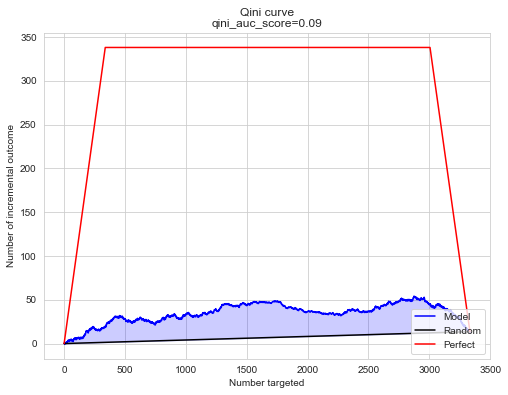

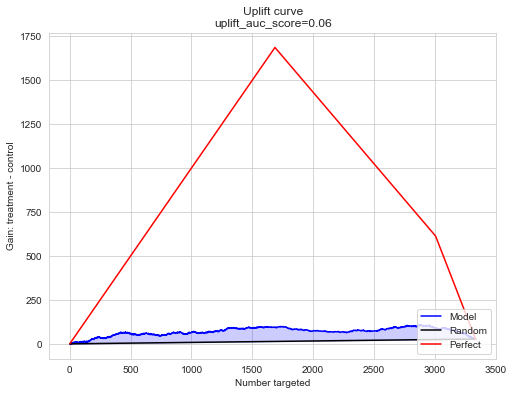

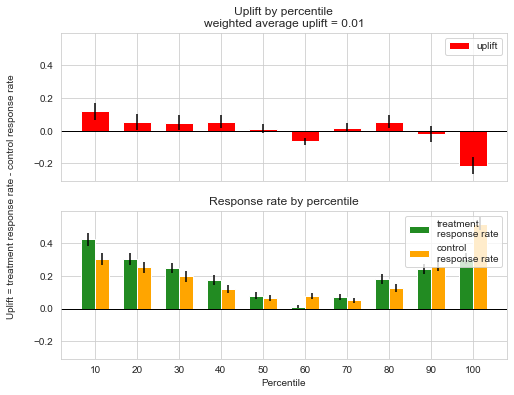

In [38]:
# visualize result
from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile

plot_qini_curve(y_true=y_test, uplift=uplift_preds, treatment=x_test[treatmentVariable])
plot_uplift_curve(y_true=y_test, uplift=uplift_preds, treatment=x_test[treatmentVariable])
plot_uplift_by_percentile(y_true=y_test, uplift=uplift_preds, treatment=x_test[treatmentVariable], 
                          kind='bar')

In [53]:
tm_uplift_decile = uplift_by_percentile(y_true=y_test, uplift=uplift_preds, 
                                        treatment=x_test[treatmentVariable], 
                                        strategy='overall', bins=10, std=False, total=False)
print('uplift by decile: ') 
tm_uplift_decile

uplift by decile: 


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift
percentile,,,,,
10.0,156,178,0.423077,0.303371,0.119706
20.0,168,166,0.303571,0.253012,0.050559
30.0,182,152,0.247253,0.197368,0.049884
40.0,156,178,0.173077,0.117978,0.055099
50.0,165,168,0.078788,0.065476,0.013312
60.0,163,170,0.012270,0.076471,-0.064201
70.0,173,160,0.069364,0.050000,0.019364
80.0,153,180,0.183007,0.127778,0.055229
90.0,169,164,0.242604,0.262195,-0.019592


## Dummy Treatment Approach    
Single model with treatment as a binary feature.    
After the model is trained, at the scoring time it is going to be applied twice: with the treatment flag equals 1 and with the treatment flag equals 0. Subtracting these model’s outcomes for each test sample, we will get an estimate of the uplift.

In [39]:
ct = CatBoostClassifier(iterations=200, random_state=SEED, silent=True)
# define approach
sm = SoloModel(ct, method='dummy')
# fit the model
sm = sm.fit(x_train[predictors], y_train, 
            x_train[treatmentVariable])
# predict uplift
uplift_sm = sm.predict(x_test)

In [54]:
# Area Under Qini Curve
qini_auc = qini_auc_score(y_true=y_test, uplift=uplift_sm, treatment=x_test[treatmentVariable])

# Area Under Uplift Curve
uplift_auc = uplift_auc_score(y_true=y_test, uplift=uplift_sm, treatment=x_test[treatmentVariable])

# Weighted average uplift
wau = weighted_average_uplift(y_true=y_test, uplift=uplift_sm,  treatment=x_test[treatmentVariable])

print('qini_auc: ', qini_auc)
print('uplift_auc: ', uplift_auc)
print('weighted average uplift: ', wau)

qini_auc:  0.11069689844566122
uplift_auc:  0.07367317217102896
weighted average uplift:  0.0086107653095905


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11d5742e8>,
      dtype=object)

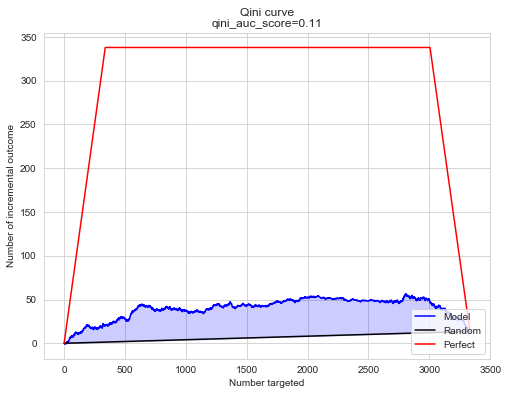

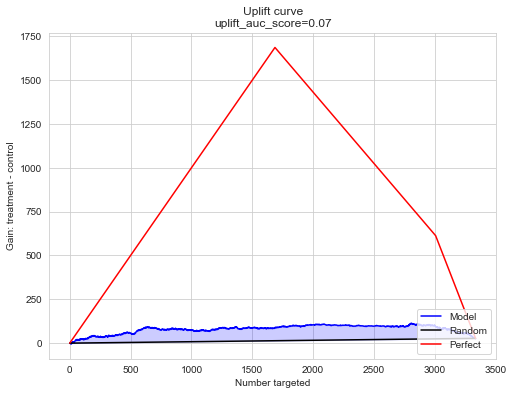

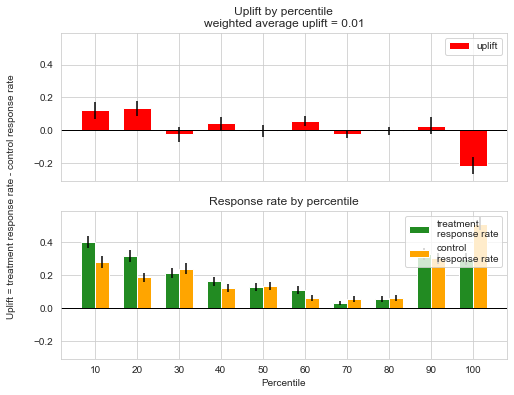

In [41]:
plot_qini_curve(y_true=y_test, uplift=uplift_sm, treatment=x_test[treatmentVariable])
plot_uplift_curve(y_true=y_test, uplift=uplift_sm, treatment=x_test[treatmentVariable])
plot_uplift_by_percentile(y_true=y_test, uplift=uplift_sm, treatment=x_test[treatmentVariable], 
                          kind='bar')


In [55]:
uplift_decile = uplift_by_percentile(y_true=y_test, uplift=uplift_sm, 
                                        treatment=x_test[treatmentVariable], 
                                        strategy='overall', bins=10, std=False, total=False)
print('uplift by decile: ') 
uplift_decile

uplift by decile: 


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift
percentile,,,,,
10.0,167,167,0.401198,0.281437,0.119760
20.0,157,177,0.318471,0.186441,0.132031
30.0,179,155,0.212291,0.238710,-0.026419
40.0,171,163,0.163743,0.122699,0.041043
50.0,163,170,0.128834,0.135294,-0.006460
60.0,162,171,0.111111,0.058480,0.052632
70.0,167,166,0.029940,0.054217,-0.024277
80.0,167,166,0.053892,0.060241,-0.006349
90.0,161,172,0.329193,0.302326,0.026867


## Treatment Interaction Approach
Single model including treatment interactions.    
Add the product of each feature and the treatment flag as new features.

In [42]:
ct2 = CatBoostClassifier(iterations=200, random_state=SEED, silent=True)
# define approach
sm2 = SoloModel(ct2, method='treatment_interaction')
# fit the model
sm2 = sm2.fit(x_train[predictors], y_train, 
            x_train[treatmentVariable])
# predict uplift
uplift_sm2 = sm2.predict(x_test)

In [49]:
# Area Under Qini Curve
qini_auc = qini_auc_score(y_true=y_test, uplift=uplift_sm2, treatment=x_test[treatmentVariable])

# Area Under Uplift Curve
uplift_auc = uplift_auc_score(y_true=y_test, uplift=uplift_sm2, treatment=x_test[treatmentVariable])

# Weighted average uplift
wau = weighted_average_uplift(y_true=y_test, uplift=uplift_sm2,  treatment=x_test[treatmentVariable])

#print('uplift_at_k: ', uplift_at_k)
print('qini_auc: ', qini_auc)
print('uplift_auc: ', uplift_auc)
print('weighted average uplift: ', wau)

qini_auc:  0.08718699711821329
uplift_auc:  0.058172254027845746
weighted average uplift:  0.006847364365518806


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11dc2f160>,
      dtype=object)

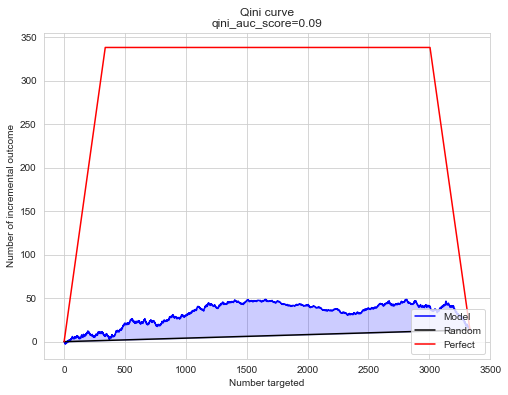

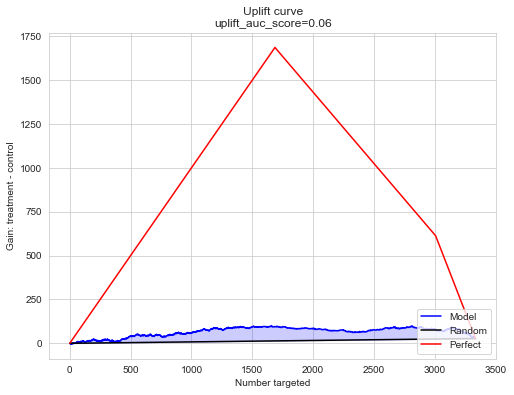

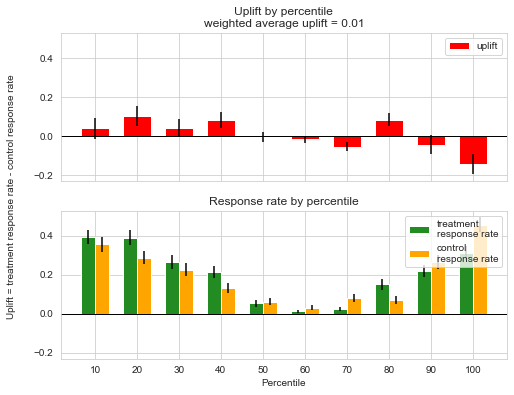

In [48]:
plot_qini_curve(y_true=y_test, uplift=uplift_sm2, treatment=x_test[treatmentVariable])
plot_uplift_curve(y_true=y_test, uplift=uplift_sm2, treatment=x_test[treatmentVariable])
plot_uplift_by_percentile(y_true=y_test, uplift=uplift_sm2, treatment=x_test[treatmentVariable], 
                          kind='bar')

In [56]:
uplift_decile = uplift_by_percentile(y_true=y_test, uplift=uplift_sm2, 
                                        treatment=x_test[treatmentVariable], 
                                        strategy='overall', bins=10, std=False, total=False)
print('uplift by decile: ') 
uplift_decile

uplift by decile: 


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift
percentile,,,,,
10.0,168,166,0.392857,0.355422,0.037435
20.0,167,167,0.389222,0.287425,0.101796
30.0,166,168,0.265060,0.226190,0.038870
40.0,168,166,0.214286,0.132530,0.081756
50.0,152,181,0.052632,0.060773,-0.008142
60.0,170,163,0.011765,0.030675,-0.018910
70.0,170,163,0.023529,0.079755,-0.056225
80.0,159,174,0.150943,0.068966,0.081978
90.0,178,155,0.219101,0.264516,-0.045415
